In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import glob
from PIL import Image
import re

In [ ]:
drive.mount('/content/drive', force_remount=True)

basePath = 'drive/Shareddrives/BA865 Group Project/data_folders/train'

# resize images as apporiate
image_size = (256,256)
#image_size = (32,32)

Mounted at /content/drive


## Data Ingestion and Preprocessing

In [ ]:
# read images
def read_images(imageType):
  image_list = []
  image_list2 = []
  label = []
  label2 = []
 # use regular expression to filter for data ingestion
  for file in glob.glob(f"{basePath}/{imageType}/*_[1234][0-9]{9}.png"):
    im=Image.open(file)
    im=im.resize(size=image_size)
    image_list.append(np.divide(np.array(im),255))
    label.append(file[71:79])

  for file in glob.glob(f"{basePath}/{imageType}/*_[1-9]{9}.png"):
    im=Image.open(file)
    im=im.resize(size=image_size)
    image_list2.append(np.divide(np.array(im),255))
    label2.append(file[71:78])
    
  image_list.extend(image_list2)
  label.extend(label2)
  
  return np.stack(image_list), label

In [ ]:
# read images by class
FB, FB_id = read_images("FB_png_train")
TB, TB_id = read_images("TB_png_train")
FM, FM_id = read_images("FM_png_train")
TM, TM_id = read_images("TM_png_train")

# assign labels
FB_df = pd.DataFrame({'uuid':FB_id, 'label': 'FB'})
TB_df = pd.DataFrame({'uuid':TB_id, 'label': 'TB'})
FM_df = pd.DataFrame({'uuid':FM_id, 'label': 'FM'})
TM_df = pd.DataFrame({'uuid':TM_id, 'label': 'TM'})

label_train = pd.concat([FB_df, TB_df, FM_df, TM_df],ignore_index=True)
image_train = np.concatenate((FB, TB, FM, TM,), axis = 0)
image_train = np.stack((image_train,)*3, axis=-1)

In [ ]:
image_train.shape

(1378, 256, 256, 3)

In [ ]:
# shuffle data
shuffled_indices= list(label_train.index)
np.random.shuffle(shuffled_indices)

image_train = image_train[shuffled_indices]
label_train = label_train.iloc[shuffled_indices]
label_train = pd.get_dummies(label_train.label)

In [ ]:
# balance check
label_train.value_counts()

FB  FM  TB  TM
0   1   0   0     590
1   0   0   0     478
0   0   0   1     170
        1   0     140
dtype: int64

In [ ]:
# read holdout images
basePath_holdout = 'drive/Shareddrives/BA865 Group Project/data_folders/test'

def read_images_hold(imageType):
  image_list = []
  image_list2 = []
  label = []
  label2 = []
 # use regular expression to filter for data ingestion
  for file in glob.glob(f"{basePath_holdout}/{imageType}/*_[1234][0-9]{9}.png"):
    im=Image.open(file)
    im=im.resize(size=image_size)
    image_list.append(np.divide(np.array(im),255))
    label.append(file[69:77])

  for file in glob.glob(f"{basePath_holdout}/{imageType}/*_[1-9]{9}.png"):
    im=Image.open(file)
    im=im.resize(size=image_size)
    image_list2.append(np.divide(np.array(im),255))
    label2.append(file[69:76])
    
  image_list.extend(image_list2)
  label.extend(label2)
  
  return np.stack(image_list), label

In [ ]:
FB_hold, FB_id_hold = read_images_hold("FB_png_test")
TB_hold, TB_id_hold = read_images_hold("TB_png_test")
FM_hold, FM_id_hold = read_images_hold("FM_png_test")
TM_hold, TM_id_hold = read_images_hold("TM_png_test")

# assign labels
FB_df_hold = pd.DataFrame({'uuid':FB_id_hold, 'label': 'FB'})
TB_df_hold = pd.DataFrame({'uuid':TB_id_hold, 'label': 'TB'})
FM_df_hold = pd.DataFrame({'uuid':FM_id_hold, 'label': 'FM'})
TM_df_hold = pd.DataFrame({'uuid':TM_id_hold, 'label': 'TM'})

label_hold = pd.concat([FB_df_hold, TB_df_hold, FM_df_hold, TM_df_hold],ignore_index=True)
image_hold = np.concatenate((FB_hold, TB_hold, FM_hold, TM_hold), axis = 0)
image_hold = np.stack((image_hold,)*3, axis=-1)
label_hold = pd.get_dummies(label_hold.label)

## Build our CNN model from Scratch

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
data_augmentation = keras.Sequential([layers.RandomFlip("horizontal"),layers.RandomRotation(0.1),layers.RandomZoom(0.2)])

def build_model():
  input_image = layers.Input(shape=(image_train.shape[1],image_train.shape[2],image_train.shape[3]))
  x = data_augmentation(input_image)
  x = layers.Conv2D(filters=32,kernel_size=3, strides=2, padding="same",activation="relu")(input_image)
  x = layers.MaxPool2D(2, strides=2)(x)
  x = layers.Conv2D(filters=64,kernel_size=3, strides=2, padding="same",activation="relu")(x)
  x = layers.MaxPool2D(2, strides=2)(x)
  x = layers.GlobalMaxPooling2D()(x)
  x = layers.Dense(16, activation = 'relu', kernel_regularizer = 'l2')(x)
  x = layers.Dropout(0.3)(x)
  final_output = layers.Dense(4, activation='softmax')(x)
  

  branch_model = keras.Model(inputs=input_image,outputs=final_output)
  branch_model.compile(optimizer="adam",loss="categorical_crossentropy",metrics='accuracy')
  return branch_model

In [ ]:
model = build_model()
keras.utils.plot_model(model,show_shapes=True)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 global_max_pooling2d_1 (Glo  (None, 64)               0   

In [ ]:
### PROVIDE YOUR CODE TO EVALUATE FIT / EVALUATE YOUR MODEL'S ACCURACY
folds = 5
num_val_samples = len(image_train)//5
num_epochs = 25
batch_size = 25
all_train_acc_histories, all_val_acc_histories = [],[]

for i in range(folds):

    print("Processing fold #:",i+1)
    
    val_image = image_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = label_train[i * num_val_samples: (i + 1) * num_val_samples]
  
    train_image = np.concatenate([image_train[:i * num_val_samples], image_train[(i + 1) * num_val_samples:]], axis=0)
    train_targets = np.concatenate([label_train[:i * num_val_samples],label_train[(i + 1) * num_val_samples:]],axis=0)
    
    model = build_model()
        
    callbacks = [keras.callbacks.ModelCheckpoint(filepath="drive/Shareddrives/BA865 Group Project/model_j.keras",
                                               save_best_only=True, monitor="val_loss")]
    history = model.fit(train_image, train_targets,
                        validation_data=(val_image, val_targets),
                        epochs=num_epochs, batch_size=batch_size,  callbacks=callbacks)
    
    train_acc_history = history.history['accuracy']
    val_acc_history = history.history['val_accuracy']

    all_train_acc_histories.append(train_acc_history)
    all_val_acc_histories.append(val_acc_history)

all_train_acc_histories = [np.mean([x[i] for x in all_train_acc_histories]) for i in range(num_epochs)]
all_val_acc_histories = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]

Processing fold #: 1
Epoch 1/25
45/45 [==============================] - 16s 324ms/step - loss: 1.5192 - accuracy: 0.3962 - val_loss: 1.4276 - val_accuracy: 0.4109
Epoch 2/25
45/45 [==============================] - 14s 320ms/step - loss: 1.4154 - accuracy: 0.4424 - val_loss: 1.3547 - val_accuracy: 0.4109
Epoch 3/25
45/45 [==============================] - 15s 324ms/step - loss: 1.3503 - accuracy: 0.4878 - val_loss: 1.2822 - val_accuracy: 0.4182
Epoch 4/25
45/45 [==============================] - 14s 321ms/step - loss: 1.2999 - accuracy: 0.4896 - val_loss: 1.2120 - val_accuracy: 0.5600
Epoch 5/25
45/45 [==============================] - 15s 325ms/step - loss: 1.2447 - accuracy: 0.5267 - val_loss: 1.1708 - val_accuracy: 0.5600
Epoch 6/25
45/45 [==============================] - 15s 324ms/step - loss: 1.1861 - accuracy: 0.5358 - val_loss: 1.0893 - val_accuracy: 0.6255
Epoch 7/25
45/45 [==============================] - 15s 329ms/step - loss: 1.0926 - accuracy: 0.6029 - val_loss: 1.0131 -

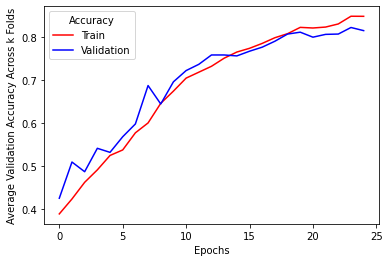

In [ ]:
# plot training accuracy
import matplotlib.pyplot as plt

plt.plot(all_train_acc_histories, c="r")
plt.plot(all_val_acc_histories,c="b")
plt.legend(['Train','Validation'],title="Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Average Validation Accuracy Across k Folds")
plt.show()

### Test on Holdout Dataset

In [ ]:
image_train.shape

(1378, 256, 256, 3)

In [ ]:
# evaluate holdout dataset using previous model
model = keras.models.load_model('drive/Shareddrives/BA865 Group Project/model_j.keras')
model.evaluate(x = image_hold, y = label_hold, batch_size = 16)

14/14 [==============================] - 1s 55ms/step - loss: 1.3077 - accuracy: 0.6651


[1.307693600654602, 0.6651162505149841]

### Performance Evaluation

In [ ]:
model = keras.models.load_model('drive/Shareddrives/BA865 Group Project/model_j.keras')

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

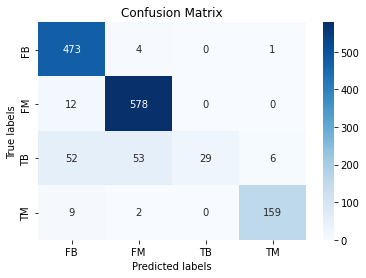

In [ ]:
y_pred_train=model.predict(image_train)

cf_matrix_train = confusion_matrix(np.array(label_train).argmax(axis=1), y_pred_train.argmax(axis=1))

import seaborn as sns
ax= plt.subplot()
sns.heatmap(cf_matrix_train, annot=True, fmt='g', ax=ax, cmap='Blues')

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['FB', 'FM', 'TB', 'TM']); ax.yaxis.set_ticklabels(['FB', 'FM', 'TB', 'TM']);

## Use LIME to Explore Decision Boundaries

     |████████████████████████████████| 275 kB 7.1 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=a772be257c81286dd5761977fa9605ed91feaf11a9e6358b5abcc5e13e522f49
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


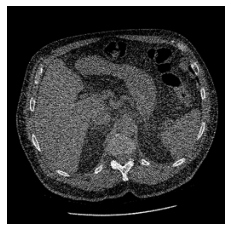

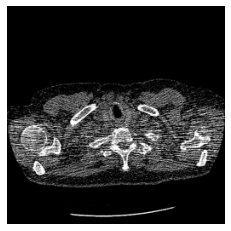

In [ ]:
import matplotlib.pyplot as plt
try:
  import lime
  from lime import lime_image
except ImportError as error:
  !pip install lime
  import lime 
  from lime import lime_image

import random
import numpy as np


plt.axis("off")
plt.imshow(image_train[0])#.astype("uint8"))
plt.show()
plt.axis("off")
plt.imshow(image_train[1])#.astype("uint8"))
plt.show()

In [ ]:
try:
  from skimage.segmentation import mark_boundaries
except ImportError as error:
  !pip install skimage 
  from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Instantiate our LIME explainer.
explainer = lime_image.LimeImageExplainer()

# Now use it to 'explain' the first test image.
explanation = explainer.explain_instance(image_train[0], model.predict, num_samples=1000, top_labels=4, hide_color=1)

print(f'The most probable label for this image is as follows: {explanation.top_labels}.')

  0%|          | 0/1000 [00:00<?, ?it/s]

The most probable label for this image is as follows: [1, 2, 3, 0].


The prediction was: [9.4687981e-05 9.7532201e-01 2.4062177e-02 5.2120525e-04]


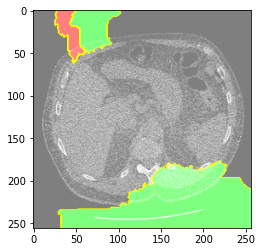

In [ ]:
print(f'The prediction was: {model.predict(image_train)[0]}')

# positive_only = True means we only display pixels that contributed positively to the respective label. 
# Notice for most labels, the pixel contributions are basically 0.
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, hide_rest=False)
# Add a plot for the associated label 
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()

# Use Pre-Trained Models

In [ ]:
# YOUR CODE HERE TO LOAD THE PRE-TRAINED MODEL
conv_base = keras.applications.vgg19.VGG19(
    weights="imagenet",
    include_top=False, # Throw away the densely connected layer at the end.
    input_shape=(256, 256, 3))

conv_base.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

In [ ]:
feature = conv_base.predict(tf.convert_to_tensor(image_train))
feature.shape

(1378, 8, 8, 512)

In [ ]:
def build_model_preTrain():

    pre_img = layers.Input(shape=(feature.shape[1], feature.shape[2], feature.shape[3]))
    
    x = layers.Flatten()(pre_img)
    x = layers.Dense(256, activation="relu", kernel_regularizer = 'l2')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64)(x)
    final_output = layers.Dense(4, activation='softmax')(x)

    model_preTrain = keras.Model(inputs=pre_img,outputs=final_output)
    model_preTrain.compile(optimizer="adam",loss="categorical_crossentropy",metrics='accuracy')
    
    return model_preTrain

In [ ]:
model_pretrain = build_model_preTrain()
model_pretrain.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 8, 8, 512)]       0         
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense_10 (Dense)            (None, 256)               8388864   
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 64)                16448     
                                                                 
 dense_12 (Dense)            (None, 4)                 260       
                                                                 
Total params: 8,405,572
Trainable params: 8,405,572
Non-tra

In [ ]:
from scipy.ndimage.measurements import label
folds = 5
num_val_samples = len(feature)//5
num_epochs = 25
batch_size = 16
pre_train_acc_histories, pre_val_acc_histories = [],[]

for i in range(folds):

    print("Processing fold #:",i+1)
    
    val_image = feature[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = label_train[i * num_val_samples: (i + 1) * num_val_samples]
  
    train_image = np.concatenate([feature[:i * num_val_samples], feature[(i + 1) * num_val_samples:]], axis=0)
    train_targets = np.concatenate([label_train[:i * num_val_samples],label_train[(i + 1) * num_val_samples:]],axis=0)
    
    model = build_model_preTrain()

    callbacks = [keras.callbacks.ModelCheckpoint(filepath="model_pretrained.keras",
                                               save_best_only=True, monitor="val_loss")]
    history = model.fit(train_image, train_targets,
                        validation_data=(val_image, val_targets),
                        epochs=num_epochs, batch_size=batch_size,  callbacks=callbacks)
    
    train_acc_history = history.history['accuracy']
    val_acc_history = history.history['val_accuracy']

    pre_train_acc_histories.append(train_acc_history)
    pre_val_acc_histories.append(val_acc_history)

pre_train_acc_histories = [np.mean([x[i] for x in pre_train_acc_histories]) for i in range(num_epochs)]
pre_val_acc_histories = [np.mean([x[i] for x in pre_val_acc_histories]) for i in range(num_epochs)]

Processing fold #: 1
Epoch 1/25
69/69 [==============================] - 8s 109ms/step - loss: 4.3571 - accuracy: 0.4524 - val_loss: 2.0053 - val_accuracy: 0.6145
Epoch 2/25
69/69 [==============================] - 11s 152ms/step - loss: 1.6814 - accuracy: 0.6174 - val_loss: 1.3179 - val_accuracy: 0.7891
Epoch 3/25
69/69 [==============================] - 7s 95ms/step - loss: 1.2904 - accuracy: 0.6519 - val_loss: 1.1710 - val_accuracy: 0.8145
Epoch 4/25
69/69 [==============================] - 8s 109ms/step - loss: 1.2683 - accuracy: 0.5721 - val_loss: 1.0702 - val_accuracy: 0.7491
Epoch 5/25
69/69 [==============================] - 8s 109ms/step - loss: 1.1777 - accuracy: 0.5630 - val_loss: 0.9566 - val_accuracy: 0.7745
Epoch 6/25
69/69 [==============================] - 7s 105ms/step - loss: 1.1748 - accuracy: 0.5458 - val_loss: 1.6474 - val_accuracy: 0.3855
Epoch 7/25
69/69 [==============================] - 7s 104ms/step - loss: 1.3084 - accuracy: 0.4370 - val_loss: 1.0545 - val_ac

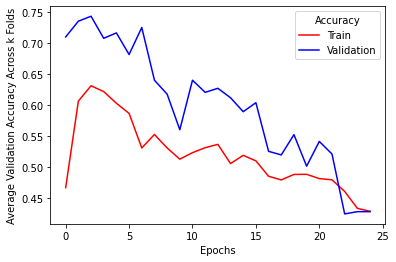

In [ ]:
# plot training accuracy
import matplotlib.pyplot as plt

plt.plot(pre_train_acc_histories, c="r")
plt.plot(pre_val_acc_histories,c="b")
plt.legend(['Train','Validation'],title="Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Average Validation Accuracy Across k Folds")
plt.show()

In [ ]:
# # evaluate pretrained model with holdout dataset
# feature_test = conv_base.predict(tf.convert_to_tensor(image_hold))
# model_pretrained = keras.models.load_model('model_pretrained.keras')
# model_pretrained.evaluate(feature_test, label_hold)

## Going Forward..



*   Get more image samples (we only have 100 scan samples)
*   Explore how to use DCM files and 3D convolutional layers to retain the spacial information on scans
*   Encorporate other features (eg. patient age, gender, habit)




